In [1]:
# Required packages
import os
import pandas as pd
from PIL import Image
import pickle

## Extract information from datasets

In [2]:
# Read file with labels and patient information
xl_file = pd.ExcelFile('HP_WSI-CoordAllAnnotatedPatches.xlsx')
patient = pd.read_csv('PatientDiagnosis.csv')

dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}

df = dfs['Sheet1']
df = df.loc[df['Presence'] != 0] # Delete uncertain cases

In [3]:
def extract_data(source_folder, patients, labelled=False, data=None, max_patients=None, only_sane=False):
    ''' 
    Function to extract information from the datasets.
    It creates a dictionary where:
    - Keys are patient codes.
    - Each patient entry is a list of dictionaries with 'img' (the image itself in RGB) and 'label' (bacteria presence).
    - Additionally, if labelled=True, a 'patient_label' key is added to indicate if any of the patient's images have bacteria.
      If labelled=False, the patient's overall label is inferred from patients['DENSITAT'].
    - max_patients limits the maximum number of patients to process.
    - If only_sane=True, only those patients labelled as not infected will be stored in the dictionary.
    '''
    
    # Dictionary to store the results
    patient_data = {}
    num_patients = 0  # Track the number of processed patients

    # Step 1: Loop through each unique patient code
    for patient in patients['CODI'].unique():
        
        # Step 2: Check if the maximum number of patients has been reached
        if max_patients is not None and num_patients >= max_patients:
            break
        
        # Step 3: Construct possible paths for the patient folder and check existence
        pat_path = os.path.join(source_folder, f"{patient}_0")
        if not os.path.exists(pat_path):
            pat_path = os.path.join(source_folder, f"{patient}_1")
            if not os.path.exists(pat_path):
                print(f"Patient folder does not exist: {pat_path}")
                continue
        
        # Step 4: List all image files with accepted extensions in the patient folder
        image_files = [f for f in os.listdir(pat_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            continue  # Skip patients with no images
        
        # Initialize the list for this patient's image entries
        patient_entries = []

        # Step 5: Determine the patient-level label if data is unlabelled
        if not labelled:
            densitat_value = patients.loc[patients['CODI'] == patient, 'DENSITAT'].values[0]
            patient_label = 1 if densitat_value != 'NEGATIVA' else -1
            # If only_sane is True and patient is infected, skip this patient
            if only_sane and patient_label == 1:
                continue
        
        # Step 6: Process each image in the patient's folder
        for filename in image_files:
            src_path = os.path.join(pat_path, filename)
            
            # Load the image and convert it to RGB format
            img = Image.open(src_path).convert('RGB')
            
            if labelled:
                # Labelled case
                window_id = filename.split('_')[0].split('.')[0].lstrip('0') or '0'
                
                # Extract information by matching patient and window ID
                label_info = data[(data['Pat_ID'] == patient) & (data['Window_ID'] == int(window_id))]
                if label_info.empty:
                    continue  # Skip if no label is found
                
                # Get the presence label (1 for bacteria, -1 for no bacteria)
                label = label_info.iloc[0]['Presence']
                entry = {'img': img, 'label': label}
            else:
                # Unlabelled case: No image-specific labels; overall patient label will be used
                entry = {'img': img, 'label': None}
            
            # Append the image entry to this patient's data
            patient_entries.append(entry)
        
        # Step 7: Determine patient-level label for both labelled and unlabelled cases
        if labelled:
            # For labelled data, assign patient-level label based on any positive image label
            patient_has_bacteria = any(e['label'] == 1 for e in patient_entries)
            if only_sane and patient_has_bacteria:
                continue  # Skip infected patients if only_sane is True
            
            # Append patient-level label based on the presence of bacteria in any image
            patient_entries.append({'patient_label': 1 if patient_has_bacteria else -1})
        else:
            # Unlabelled data: Use inferred patient-level label from DENSITAT
            patient_entries.append({'patient_label': patient_label})

        # Step 8: Add the patient data to the main dictionary and increment the patient count
        patient_data[patient] = patient_entries
        num_patients += 1

    return patient_data


In [4]:
# Calling function to process different datasets
train_set = extract_data("Cropped", patient, max_patients=20, only_sane=True)
test_set = extract_data("Annotated", patient, labelled=True, data=df)
unseen_data = extract_data("HoldOut", patient, max_patients=20)

Patient folder does not exist: Cropped\B22-01_1
Patient folder does not exist: Cropped\B22-02_1
Patient folder does not exist: Cropped\B22-03_1
Patient folder does not exist: Cropped\B22-04_1
Patient folder does not exist: Cropped\B22-05_1
Patient folder does not exist: Cropped\B22-06_1
Patient folder does not exist: Cropped\B22-07_1
Patient folder does not exist: Cropped\B22-08_1
Patient folder does not exist: Cropped\B22-09_1
Patient folder does not exist: Cropped\B22-10_1
Patient folder does not exist: Cropped\B22-11_1
Patient folder does not exist: Cropped\B22-12_1
Patient folder does not exist: Cropped\B22-13_1
Patient folder does not exist: Cropped\B22-14_1
Patient folder does not exist: Cropped\B22-15_1
Patient folder does not exist: Cropped\B22-16_1
Patient folder does not exist: Cropped\B22-17_1
Patient folder does not exist: Cropped\B22-18_1
Patient folder does not exist: Cropped\B22-19_1
Patient folder does not exist: Cropped\B22-20_1
Patient folder does not exist: Cropped\B

In [5]:
# Save data onto pickle files
with open('train_set.pkl', 'wb') as f:
    pickle.dump(train_set, f)
with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)
with open('unseen_data.pkl', 'wb') as f:
    pickle.dump(unseen_data, f)

### Visualization

In [6]:
train_set['B22-25']

[{'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label':

In [ ]:
train_set['B22-25'][69]

{'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None}

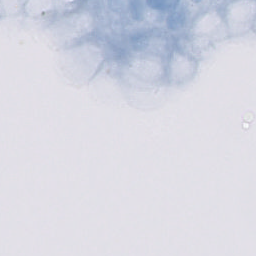

In [8]:
train_set['B22-25'][69]['img']

In [9]:
test_set['B22-25']

[{'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': -1},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': -1},
 {'patient_label': -1}]

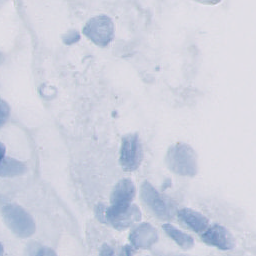

In [10]:
test_set['B22-25'][0]['img']

In [11]:
unseen_data['B22-01']

[{'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label':

In [12]:
unseen_data['B22-01'][43]

{'img': <PIL.Image.Image image mode=RGB size=256x256>, 'label': None}

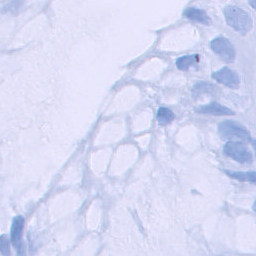

In [13]:
unseen_data['B22-01'][43]['img']